In [1]:
%load_ext autoreload
%autoreload 2

# Análisis Exploratorio y Preprocesamiento de Datos
## Predicción de Características de Vuelo en Planeador

**Objetivo:** Analizar datos y preprocesar para predecir múltiples características de vuelo usando datos meteorológicos.

**Autor:** Estanislao  
**Fecha:** Noviembre 2024

---

## ⚠️ IMPORTANTE: Este notebook SOLO hace EDA y Preprocesamiento

**Feature Engineering se hará en un notebook separado más adelante.**

---

## Estructura del Notebook

### PARTE 1: ANÁLISIS EXPLORATORIO (EDA)
1. Setup y Carga de Datos
2. Resumen del Dataset
3. Análisis de Targets
4. Correlaciones

### PARTE 2: PREPROCESAMIENTO
1. Split Temporal
2. Identificación y Limpieza de Columnas
3. Tratamiento de Outliers
4. Imputación de Missing Values

---
# PARTE 1: ANÁLISIS EXPLORATORIO

---

## 1. Setup y Carga de Datos

In [2]:
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
sys.path.append('../utils')
from eda_functions import *
from data_processing import *
import matplotlib.pyplot as plt
configurar_visualizacion()

In [3]:
# Cargar dataset
df = cargar_dataset('../data/processed/dataset_FINAL_GRID.csv')

print(f"\nPrimeras filas:")
df.head()

✓ Dataset cargado: (387, 181)

Primeras filas:


,fecha,pilot,glider,competition_id,altura_max_m,altura_min_m,altura_despegue_m,altura_aterrizaje_m,ganancia_altura_m,rango_altura_m,...,wind_speed_09h,wind_speed_10h,wind_speed_11h,wind_speed_12h,wind_speed_13h,wind_speed_14h,wind_speed_15h,wind_speed_16h,wind_speed_17h,wind_speed_18h
0,2024-01-08,Miguel Serrano,ASW-20,AJ,1282,98,107,101,1181,1184,...,4.833875,5.803719,5.483726,4.872136,4.373454,4.688376,4.965358,4.776012,4.543702,4.713313
1,2024-01-08,Miguel Angel Serrano,401 Kestrel 19m,AT,1348,111,114,117,1234,1237,...,4.833875,5.803719,5.483726,4.872136,4.373454,4.688376,4.965358,4.776012,4.543702,4.713313
2,2024-01-12,Unknown,Unknown,NaN,1471,110,111,111,1360,1361,...,3.335405,3.176187,3.521591,3.922611,4.180628,4.379079,5.009855,5.251974,5.462782,5.568575
3,2024-01-12,Miguel Angel Serrano,401 Kestrel 19m,AT,1262,115,127,126,1136,1147,...,3.335405,3.176187,3.521591,3.922611,4.180628,4.379079,5.009855,5.251974,5.462782,5.568575
4,2024-01-13,Unknown,Jantar St2,NaN,1436,86,114,86,1350,1350,...,5.126120,4.850095,4.774630,5.129500,5.094105,4.963728,5.396002,4.968724,4.750961,4.907199


## 2. Resumen del Dataset

In [4]:
resumen_dataset(df)
flight_features = ["fecha","pilot","glider","competition_id","altura_max_m","altura_min_m","altura_despegue_m","altura_aterrizaje_m","ganancia_altura_m","rango_altura_m","duracion_min","duracion_horas","distancia_km","velocidad_promedio_kmh","lat_despegue","lon_despegue","hora_despegue","hora_despegue_decimal","num_gps_fixes","frecuencia_muestreo_seg","num_termicas","intensidad_termicas_mean_ms","intensidad_termicas_max_ms","intensidad_termicas_min_ms","intensidad_termicas_std_ms","altura_base_termicas_mean_m","altura_tope_termicas_mean_m","altura_base_termicas_min_m","altura_tope_termicas_max_m","ganancia_por_termica_mean_m","ganancia_por_termica_max_m","duracion_termica_mean_seg","duracion_termica_max_seg","hora_primera_termica","hora_ultima_termica","dispersion_termicas_lat","dispersion_termicas_lon","tiempo_en_termicas_min","tiempo_en_planeo_min","porcentaje_tiempo_termicas","tasa_ascenso_mean_ms","tasa_descenso_mean_ms","bearing_change_mean_deg","bearing_change_max_deg","bearing_change_std_deg","ground_speed_mean_kmh","ground_speed_max_kmh","ground_speed_min_kmh","ground_speed_std_kmh","hora_inicio_decimal","hora_fin_decimal","altura_mean_manana_m","altura_mean_mediodia_m","altura_mean_tarde1_m","altura_mean_tarde2_m","lat_min","lat_max","lon_min","lon_max","lat_centro","lon_centro","rango_lat_deg","rango_lon_deg","distancia_max_despegue_km","area_vuelo_km2","altura_std_m","altura_cv","cambio_altura_mean_m","cambio_altura_std_m","filename","flight_id"]
weather_features = ["solar_rad","precipitation","temp_2m","cloud_cover","wind_u","wind_v","pressure","boundary_layer_height","cape","skin_temp","wind_speed"]

RESUMEN DEL DATASET

Dimensiones: 387 filas x 181 columnas

Rango temporal: 2024-01-08 a 2025-11-15
Días únicos: 91

TIPOS DE DATOS
float64           161
int64              13
object              6
datetime64[ns]      1
Name: count, dtype: int64

VALORES FALTANTES
                            n_missing  pct_missing
competition_id                    134        34.63
ground_speed_std_kmh               11         2.84
intensidad_termicas_std_ms          2         0.52
dispersion_termicas_lat             2         0.52
dispersion_termicas_lon             2         0.52


## 3. Análisis de Targets

### ¿Qué vamos a predecir?

**Targets de Regresión (11 variables):**
1. `altura_max_m` - Altura máxima alcanzada
2. `altura_min_m` - Altura mínima
3. `ganancia_altura_m` - Ganancia total de altura
4. `duracion_horas` - Duración del vuelo
5. `duracion_min` - Duración en minutos
6. `distancia_km` - Distancia recorrida
7. `velocidad_promedio_kmh` - Velocidad promedio
8. `num_termicas` - Número de térmicas usadas
9. `intensidad_termicas_mean_ms` - Intensidad promedio de térmicas
10. `tiempo_en_termicas_min` - Tiempo en térmicas
11. `tasa_ascenso_mean_ms` - Tasa de ascenso promedio

**Target de Clasificación:**
- `calidad_dia` - Excelente / Bueno / Regular / Malo

In [5]:
# Definir todos los targets
targets_reg = [
    'altura_max_m',
    'ganancia_altura_m',
    'duracion_min',
    'distancia_km',
    'velocidad_promedio_kmh',
    'num_termicas',
    'intensidad_termicas_mean_ms',
    'tiempo_en_termicas_min',
    'tasa_ascenso_mean_ms'
]
target_clf = 'calidad_dia'
analizar_targets(df, targets_reg, target_clf)

ANÁLISIS DE TARGETS

▶ TARGETS DE REGRESIÓN:

altura_max_m:
  Media: 2231.61
  Mediana: 2009.00
  Std: 3417.99
  Min: 560.00
  Max: 64500.00

ganancia_altura_m:
  Media: 2091.41
  Mediana: 1861.00
  Std: 3410.69
  Min: 528.00
  Max: 64299.00

duracion_min:
  Media: 197.44
  Mediana: 202.00
  Std: 72.81
  Min: 12.30
  Max: 404.20

distancia_km:
  Media: 394.19
  Mediana: 395.10
  Std: 171.90
  Min: 12.10
  Max: 899.00

velocidad_promedio_kmh:
  Media: 116.26
  Mediana: 118.20
  Std: 18.71
  Min: 54.70
  Max: 161.70

num_termicas:
  Media: 109.14
  Mediana: 102.00
  Std: 69.99
  Min: 1.00
  Max: 323.00

intensidad_termicas_mean_ms:
  Media: 2.65
  Mediana: 2.56
  Std: 0.58
  Min: 0.47
  Max: 6.73

tiempo_en_termicas_min:
  Media: 76.60
  Mediana: 78.70
  Std: 29.11
  Min: 3.20
  Max: 152.40

tasa_ascenso_mean_ms:
  Media: 2.70
  Mediana: 2.45
  Std: 1.11
  Min: 1.51
  Max: 9.74


Claramente la altura_max_m tiene un error de medicion, con un valor maximo de 64500. 

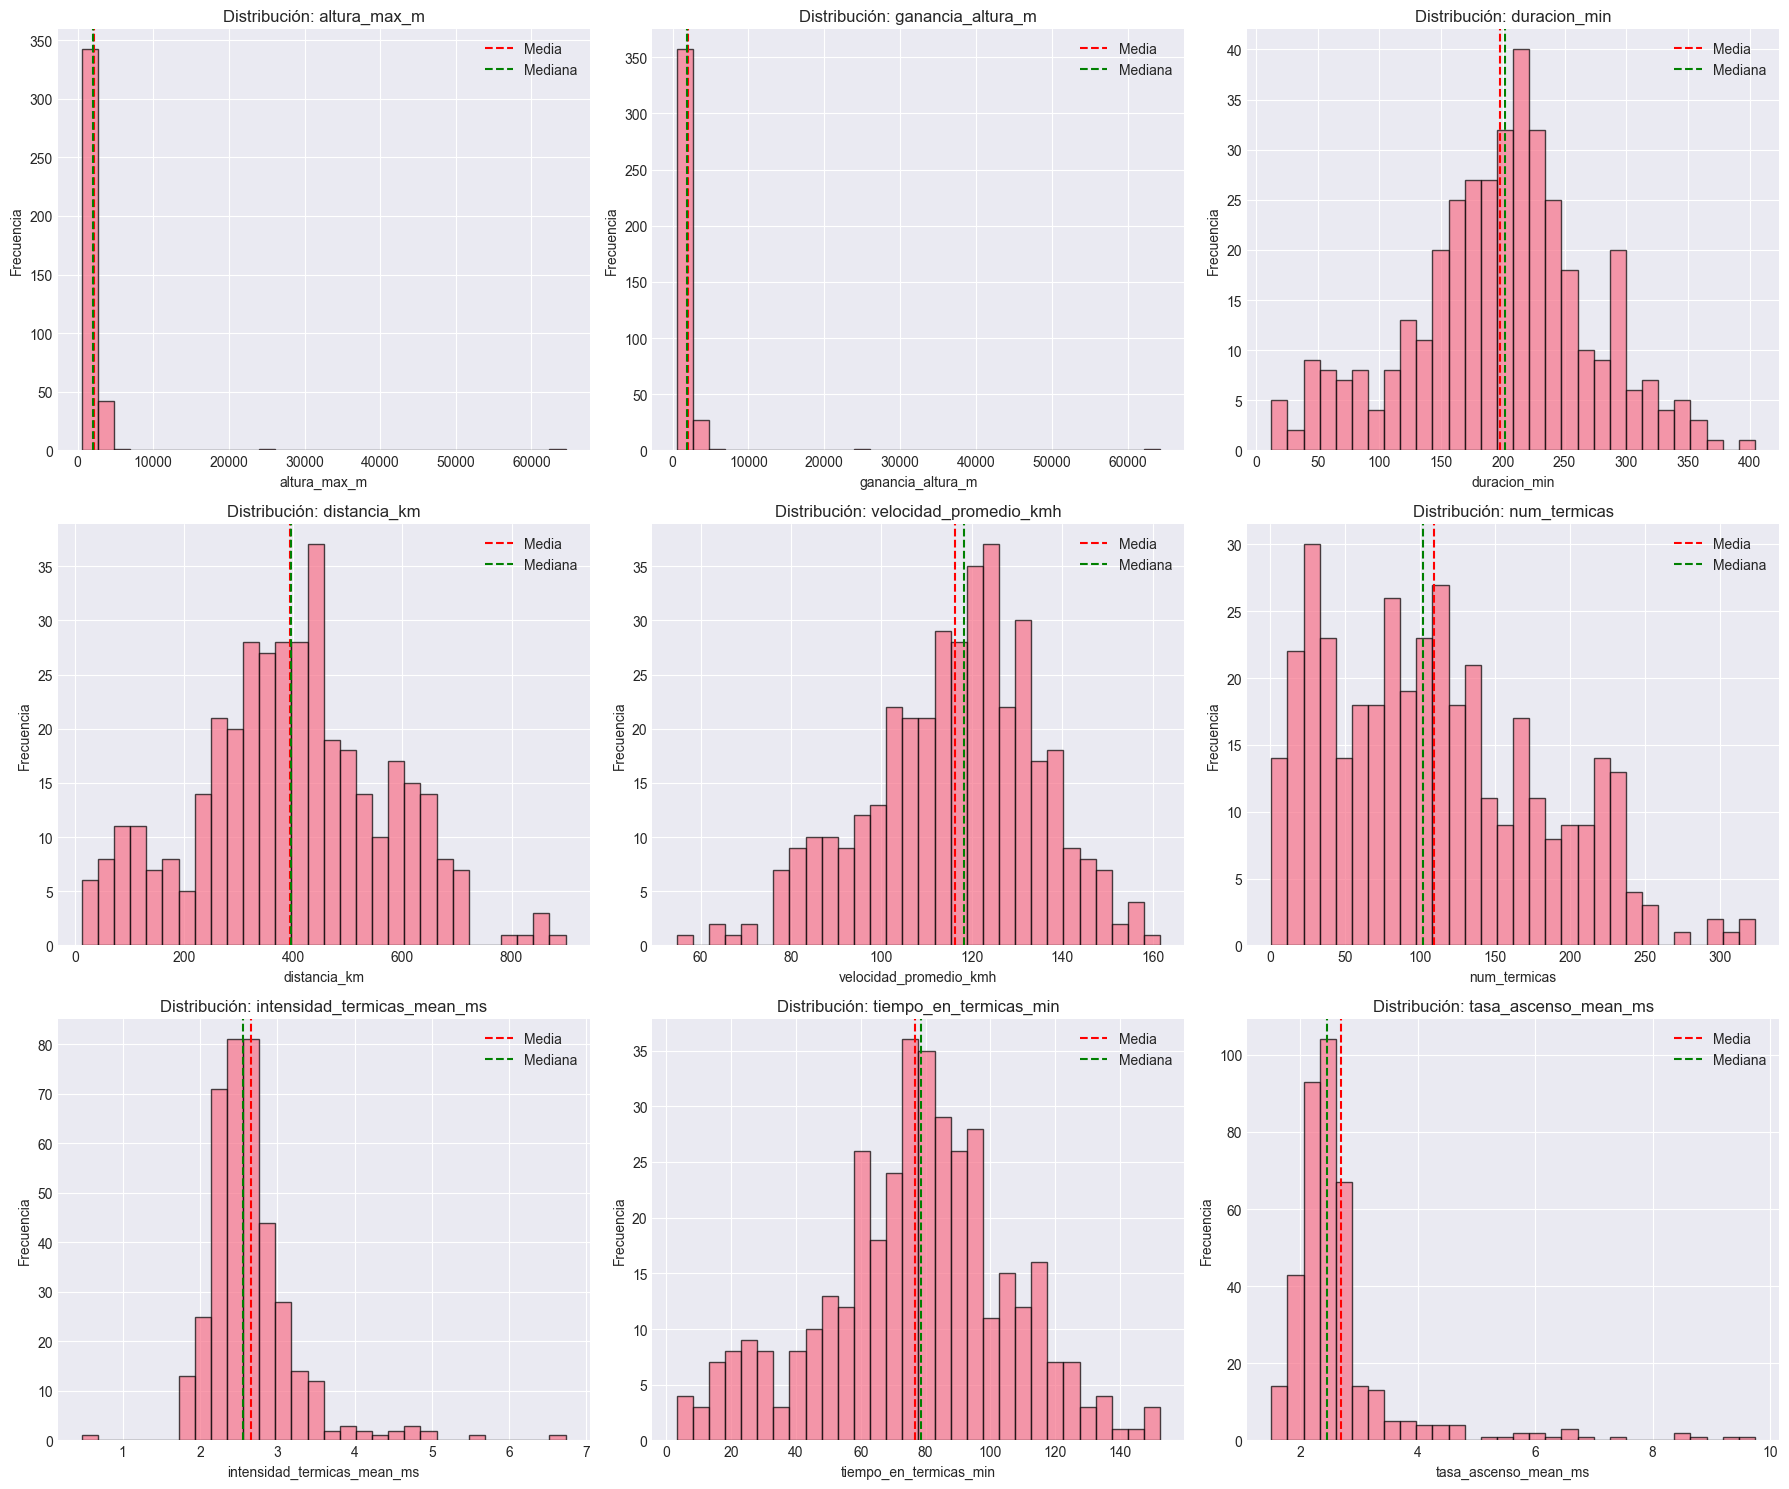

In [6]:
# Visualizar distribuciones de los primeros 6 targets
plot_distribucion_targets(df, targets_reg, None)

## 4. Correlaciones con Targets

**¿Qué features meteorológicas son más importantes?**

Primero saco las columnas del dataset que no van a ser utilizadas para la prediccion.  

Ademas nos vamos a quedar con los datos de la hora de despegue. Por mas que sea una feature que proviene de los datos del dataset de vuelos, es un dato que el usuario podria cargarle al modelo a la hora de hacer la prediccion.

In [7]:
for col in flight_features:
    if col in df.columns and col not in targets_reg and col != "hora_despegue" and col != "fecha":
        df.drop(columns=col, inplace=True)
df.head()

,fecha,altura_max_m,ganancia_altura_m,duracion_min,distancia_km,velocidad_promedio_kmh,hora_despegue,num_termicas,intensidad_termicas_mean_ms,tiempo_en_termicas_min,...,wind_speed_09h,wind_speed_10h,wind_speed_11h,wind_speed_12h,wind_speed_13h,wind_speed_14h,wind_speed_15h,wind_speed_16h,wind_speed_17h,wind_speed_18h
0,2024-01-08,1282,1181,148.1,284.2,115.2,16:01:00,45,2.41,52.9,...,4.833875,5.803719,5.483726,4.872136,4.373454,4.688376,4.965358,4.776012,4.543702,4.713313
1,2024-01-08,1348,1234,153.7,271.5,106.0,15:52:00,107,2.33,58.1,...,4.833875,5.803719,5.483726,4.872136,4.373454,4.688376,4.965358,4.776012,4.543702,4.713313
2,2024-01-12,1471,1360,160.5,318.3,119.0,16:23:00,71,3.51,59.2,...,3.335405,3.176187,3.521591,3.922611,4.180628,4.379079,5.009855,5.251974,5.462782,5.568575
3,2024-01-12,1262,1136,156.1,260.0,100.0,16:15:00,91,2.13,58.5,...,3.335405,3.176187,3.521591,3.922611,4.180628,4.379079,5.009855,5.251974,5.462782,5.568575
4,2024-01-13,1436,1350,174.9,353.2,121.1,16:40:00,79,2.24,66.0,...,5.126120,4.850095,4.774630,5.129500,5.094105,4.963728,5.396002,4.968724,4.750961,4.907199


No vamos a querer ver la correlacion de los targets con todas las features en todos sus horarios, asi que para esta parte del analisis, vamos a agregar una columna con el valor promedio para cada uno de las categorias. Esto no generará data leakeage ya que los datos se obtienen simplemente con los propios valores de la fila. 

In [8]:
df, weather_avg= add_avg(df, weather_features)
df.head()

,fecha,altura_max_m,ganancia_altura_m,duracion_min,distancia_km,velocidad_promedio_kmh,hora_despegue,num_termicas,intensidad_termicas_mean_ms,tiempo_en_termicas_min,...,precipitation_avg,temp_2m_avg,cloud_cover_avg,wind_u_avg,wind_v_avg,pressure_avg,boundary_layer_height_avg,cape_avg,skin_temp_avg,wind_speed_avg
0,2024-01-08,1282,1181,148.1,284.2,115.2,16:01:00,45,2.41,52.9,...,0.089550,24.276831,0.949274,-4.650957,1.354051,989.945875,702.891309,1118.07500,25.288940,4.905367
1,2024-01-08,1348,1234,153.7,271.5,106.0,15:52:00,107,2.33,58.1,...,0.089550,24.276831,0.949274,-4.650957,1.354051,989.945875,702.891309,1118.07500,25.288940,4.905367
2,2024-01-12,1471,1360,160.5,318.3,119.0,16:23:00,71,3.51,59.2,...,0.085402,27.657617,0.434799,-3.829167,-1.460257,994.600750,918.216287,271.55625,30.737842,4.380869
3,2024-01-12,1262,1136,156.1,260.0,100.0,16:15:00,91,2.13,58.5,...,0.085402,27.657617,0.434799,-3.829167,-1.460257,994.600750,918.216287,271.55625,30.737842,4.380869
4,2024-01-13,1436,1350,174.9,353.2,121.1,16:40:00,79,2.24,66.0,...,0.003433,29.179053,0.422537,-3.485661,-3.352786,991.304250,1148.199963,81.66875,31.548438,4.996106


In [9]:
analizar_correlaciones(df, targets_reg, top_n=3, corr_features=weather_avg)


▶ Correlaciones con altura_max_m (Top 3):
skin_temp_avg                0.117904
boundary_layer_height_avg    0.106591
temp_2m_avg                  0.103441

▶ Correlaciones con ganancia_altura_m (Top 3):
skin_temp_avg                0.108791
boundary_layer_height_avg    0.099238
temp_2m_avg                  0.094941

▶ Correlaciones con duracion_min (Top 3):
skin_temp_avg                0.366613
temp_2m_avg                  0.351005
boundary_layer_height_avg    0.347804

▶ Correlaciones con distancia_km (Top 3):
skin_temp_avg                0.442172
temp_2m_avg                  0.421989
boundary_layer_height_avg    0.387899

▶ Correlaciones con velocidad_promedio_kmh (Top 3):
skin_temp_avg                0.420582
temp_2m_avg                  0.401132
boundary_layer_height_avg    0.360918

▶ Correlaciones con num_termicas (Top 3):
skin_temp_avg                0.288821
temp_2m_avg                  0.269245
boundary_layer_height_avg    0.265335

▶ Correlaciones con intensidad_termicas_me

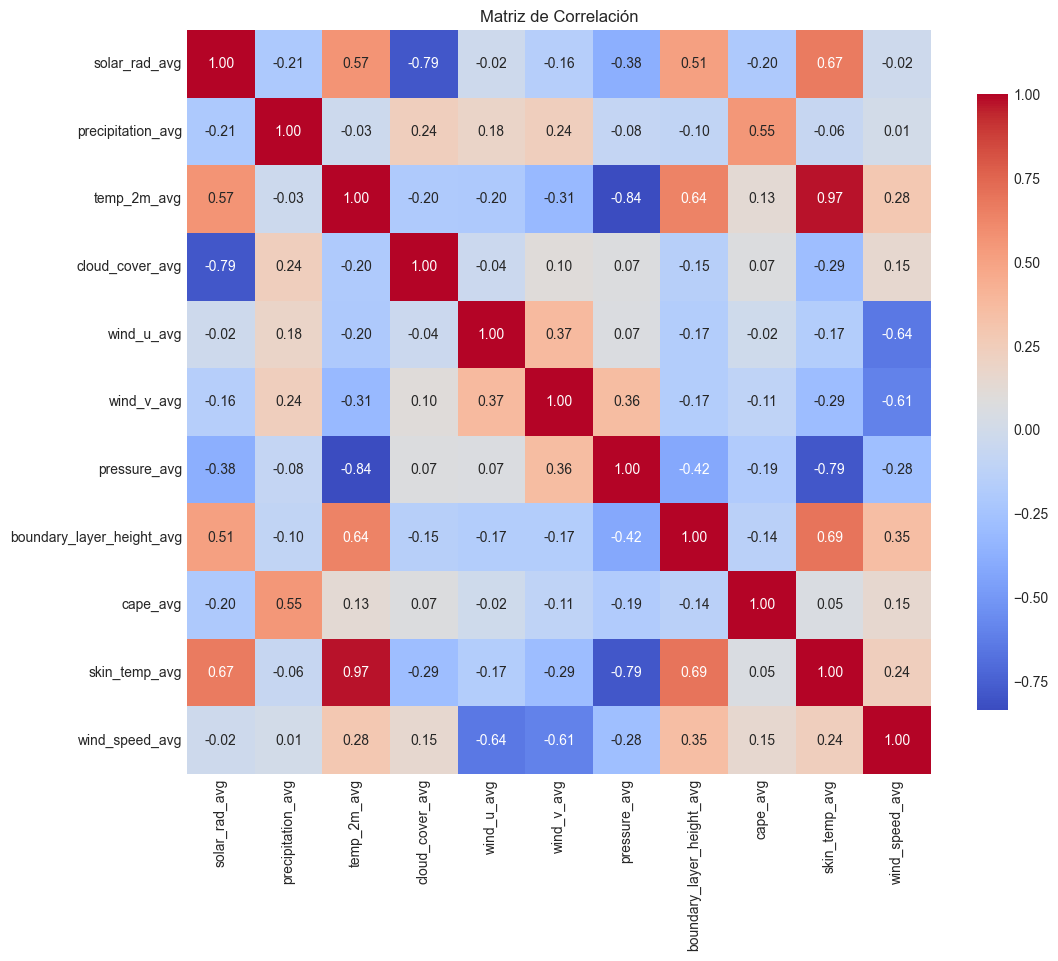

In [10]:
# Heatmap para altura_max_m
plot_correlation_matrix(df, weather_avg)

---
# PARTE 2: PREPROCESAMIENTO

---

## 5. Identificación y Limpieza de Columnas

In [11]:
# Analizar missing values
analizar_missing_values(df)

No hay valores faltantes


,columna,n_missing,pct_missing


## 5. Split Dev y Test
Si bien los datos estan ordenados segun la fecha, no tenerlas en cuenta a la hora de realizar el split no seria un problema de data leakege ya que no estan correlacionados. 

In [12]:
dev, test = split_data(df, test_size=0.2, random_state=42)

Datos divididos: Dev=(309, 132), Test=(78, 132)


## 8. Tratamiento de Outliers

**Estrategias:**

1. **Clip** (reemplazar por límites): Valor < límite_inf → límite_inf, Valor > límite_sup → límite_sup

Como el dataset es muy limitado no podemos darnos el lujo de sacar muestras, es por eso que optamos por clipear los outliers.

In [13]:
clip_outliers(dev, targets_reg)

Valores atípicos recortados en 'altura_max_m' entre percentiles 0.01 y 0.99.
Valores atípicos recortados en 'ganancia_altura_m' entre percentiles 0.01 y 0.99.
Valores atípicos recortados en 'duracion_min' entre percentiles 0.01 y 0.99.
Valores atípicos recortados en 'distancia_km' entre percentiles 0.01 y 0.99.
Valores atípicos recortados en 'velocidad_promedio_kmh' entre percentiles 0.01 y 0.99.
Valores atípicos recortados en 'num_termicas' entre percentiles 0.01 y 0.99.
Valores atípicos recortados en 'intensidad_termicas_mean_ms' entre percentiles 0.01 y 0.99.
Valores atípicos recortados en 'tiempo_en_termicas_min' entre percentiles 0.01 y 0.99.
Valores atípicos recortados en 'tasa_ascenso_mean_ms' entre percentiles 0.01 y 0.99.


,fecha,altura_max_m,ganancia_altura_m,duracion_min,distancia_km,velocidad_promedio_kmh,hora_despegue,num_termicas,intensidad_termicas_mean_ms,tiempo_en_termicas_min,...,precipitation_avg,temp_2m_avg,cloud_cover_avg,wind_u_avg,wind_v_avg,pressure_avg,boundary_layer_height_avg,cape_avg,skin_temp_avg,wind_speed_avg
0,2025-02-01,2134.0,2025.0,259.1,482.4,111.7,15:29:00,105.0,4.82,103.8,...,0.000000,30.093164,0.046570,-2.277150,-1.841032,989.168375,879.940904,205.3000,33.896533,3.176898
1,2025-01-03,1243.0,1054.0,100.8,169.2,100.7,17:19:00,6.0,2.25,40.4,...,0.002575,29.139648,0.790488,-3.769510,1.724013,994.479625,647.503223,0.0000,30.060547,4.267261
2,2024-12-07,1922.0,1854.0,155.9,317.3,122.1,17:14:00,45.0,2.84,60.1,...,0.123215,25.468066,0.819998,-3.559204,4.290520,993.836750,1507.917554,20.5625,27.458521,5.604082
3,2025-01-12,2310.0,2114.0,279.2,606.2,130.3,16:13:00,218.0,2.70,111.4,...,0.000000,30.779639,0.071082,-3.270447,-1.496068,994.458625,1343.225156,0.0000,35.753687,3.763343
4,2025-01-07,2589.0,2382.0,267.5,601.9,135.0,16:03:00,31.0,2.80,106.5,...,0.000000,30.942236,0.107538,-3.869875,-1.807927,992.914562,1273.669647,36.7875,37.417456,5.017906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2025-01-08,2709.0,2506.0,214.9,498.9,139.3,17:14:00,38.0,2.83,74.8,...,0.000000,32.582300,0.198410,-4.066588,-1.360974,991.513312,1195.395544,9.2500,37.943188,4.346150
305,2025-01-13,2286.0,2083.0,215.8,428.3,119.1,16:50:00,168.0,2.26,85.1,...,0.037432,30.160962,0.634879,-2.288354,-1.778279,991.139875,1218.072835,0.0000,35.178540,3.272434
306,2025-07-05,910.0,792.0,48.1,70.5,88.0,17:42:00,18.0,1.87,17.0,...,0.000000,13.583374,0.292236,-2.457695,-0.033144,1003.179688,332.714816,0.0000,16.435425,2.595661
307,2025-01-11,1951.0,1752.0,243.9,579.6,142.6,16:51:00,213.0,2.95,92.3,...,0.000000,30.231372,0.030826,-2.643564,-0.121515,994.430062,1342.784335,0.0000,35.190625,2.723768


## Resultados
Finalmente los datos toman la siguiente forma:

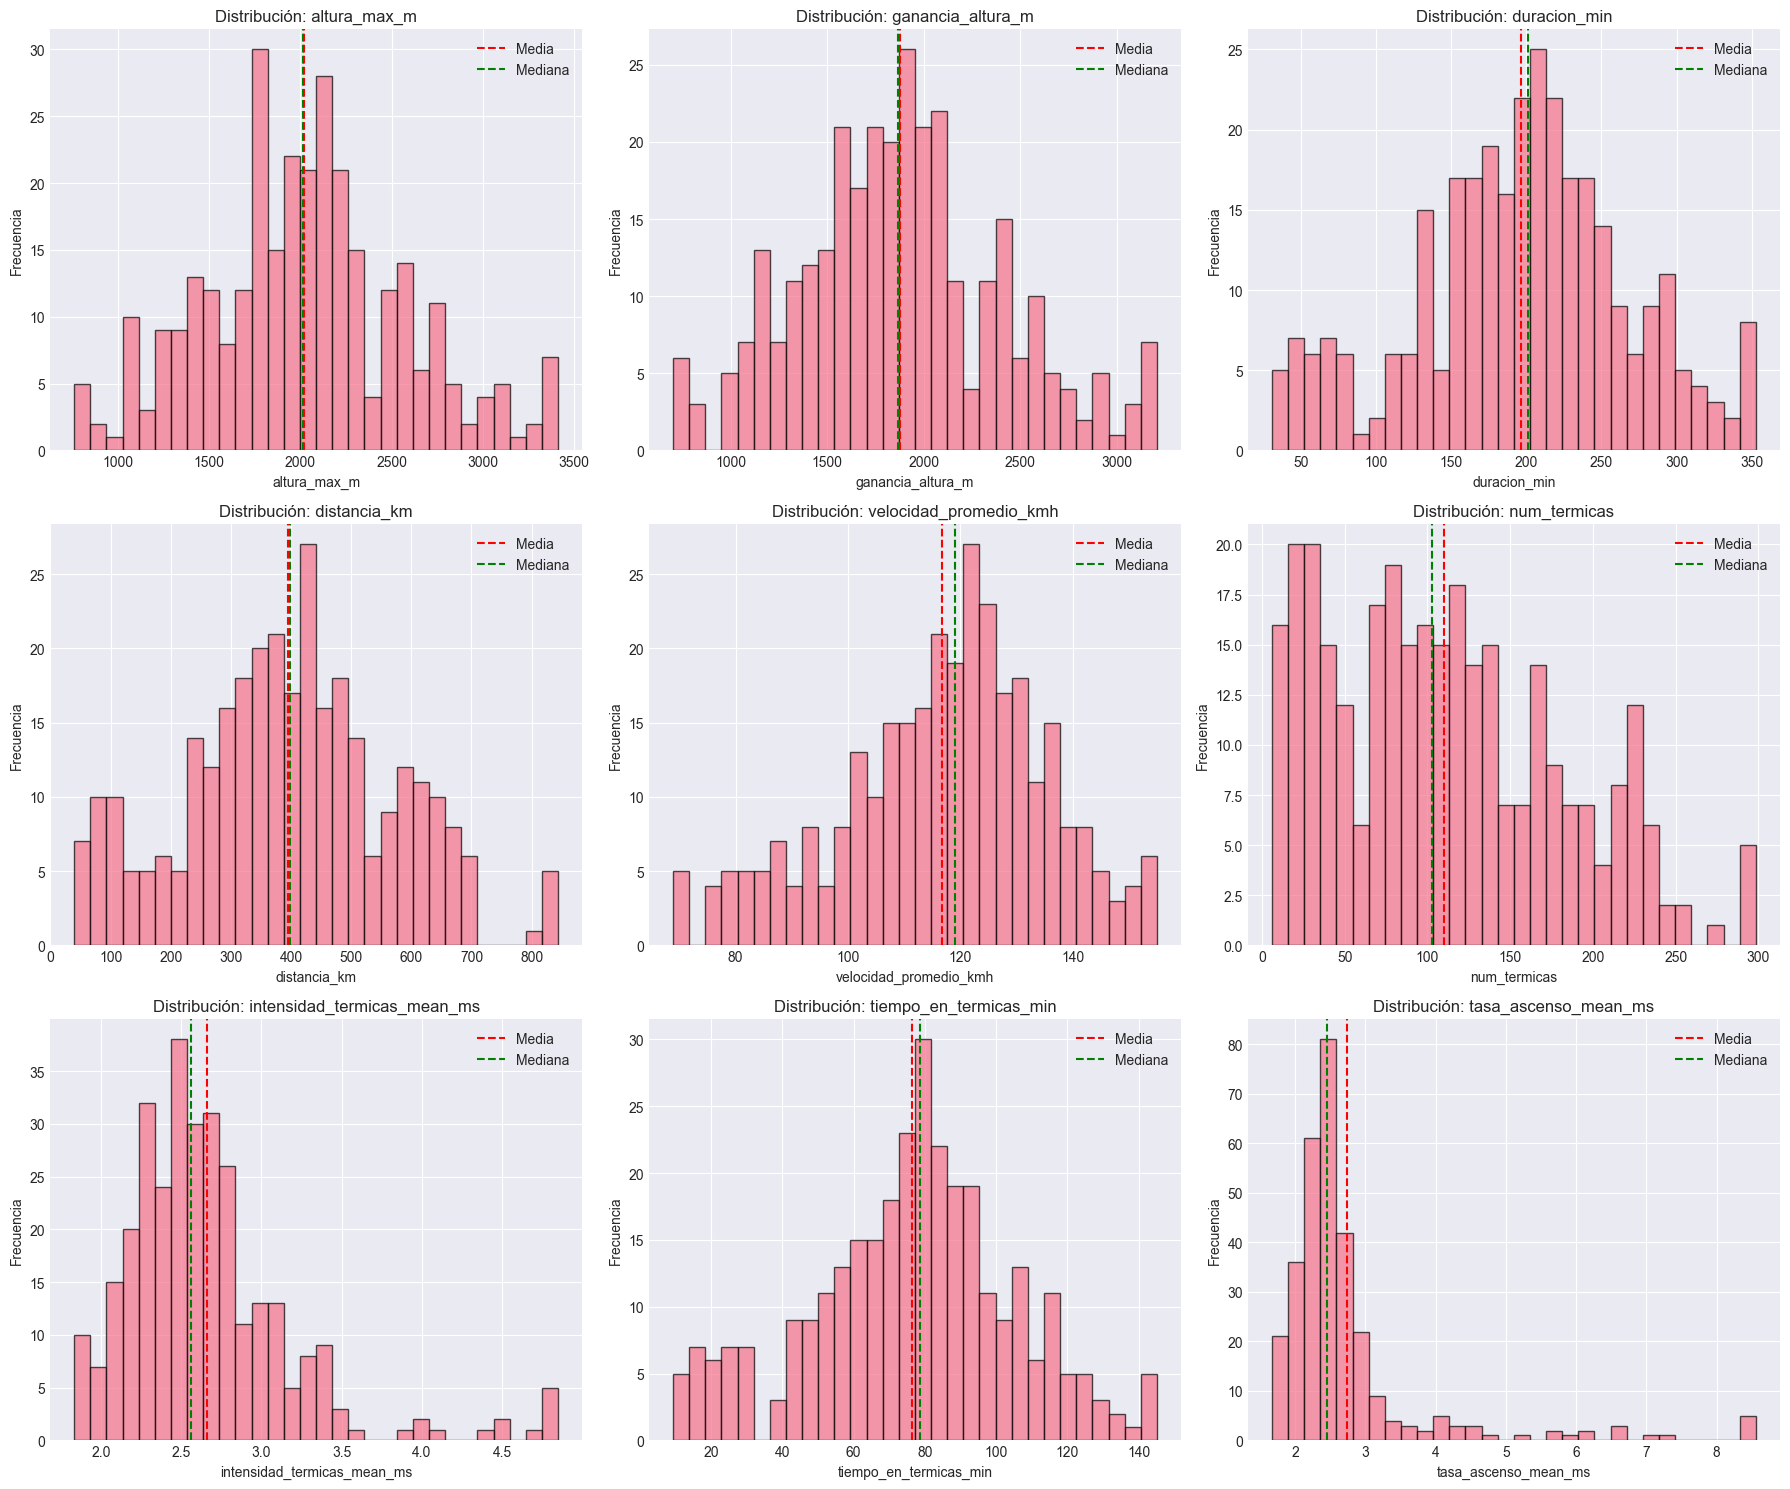

In [14]:
plot_distribucion_targets(dev, targets_reg, None)

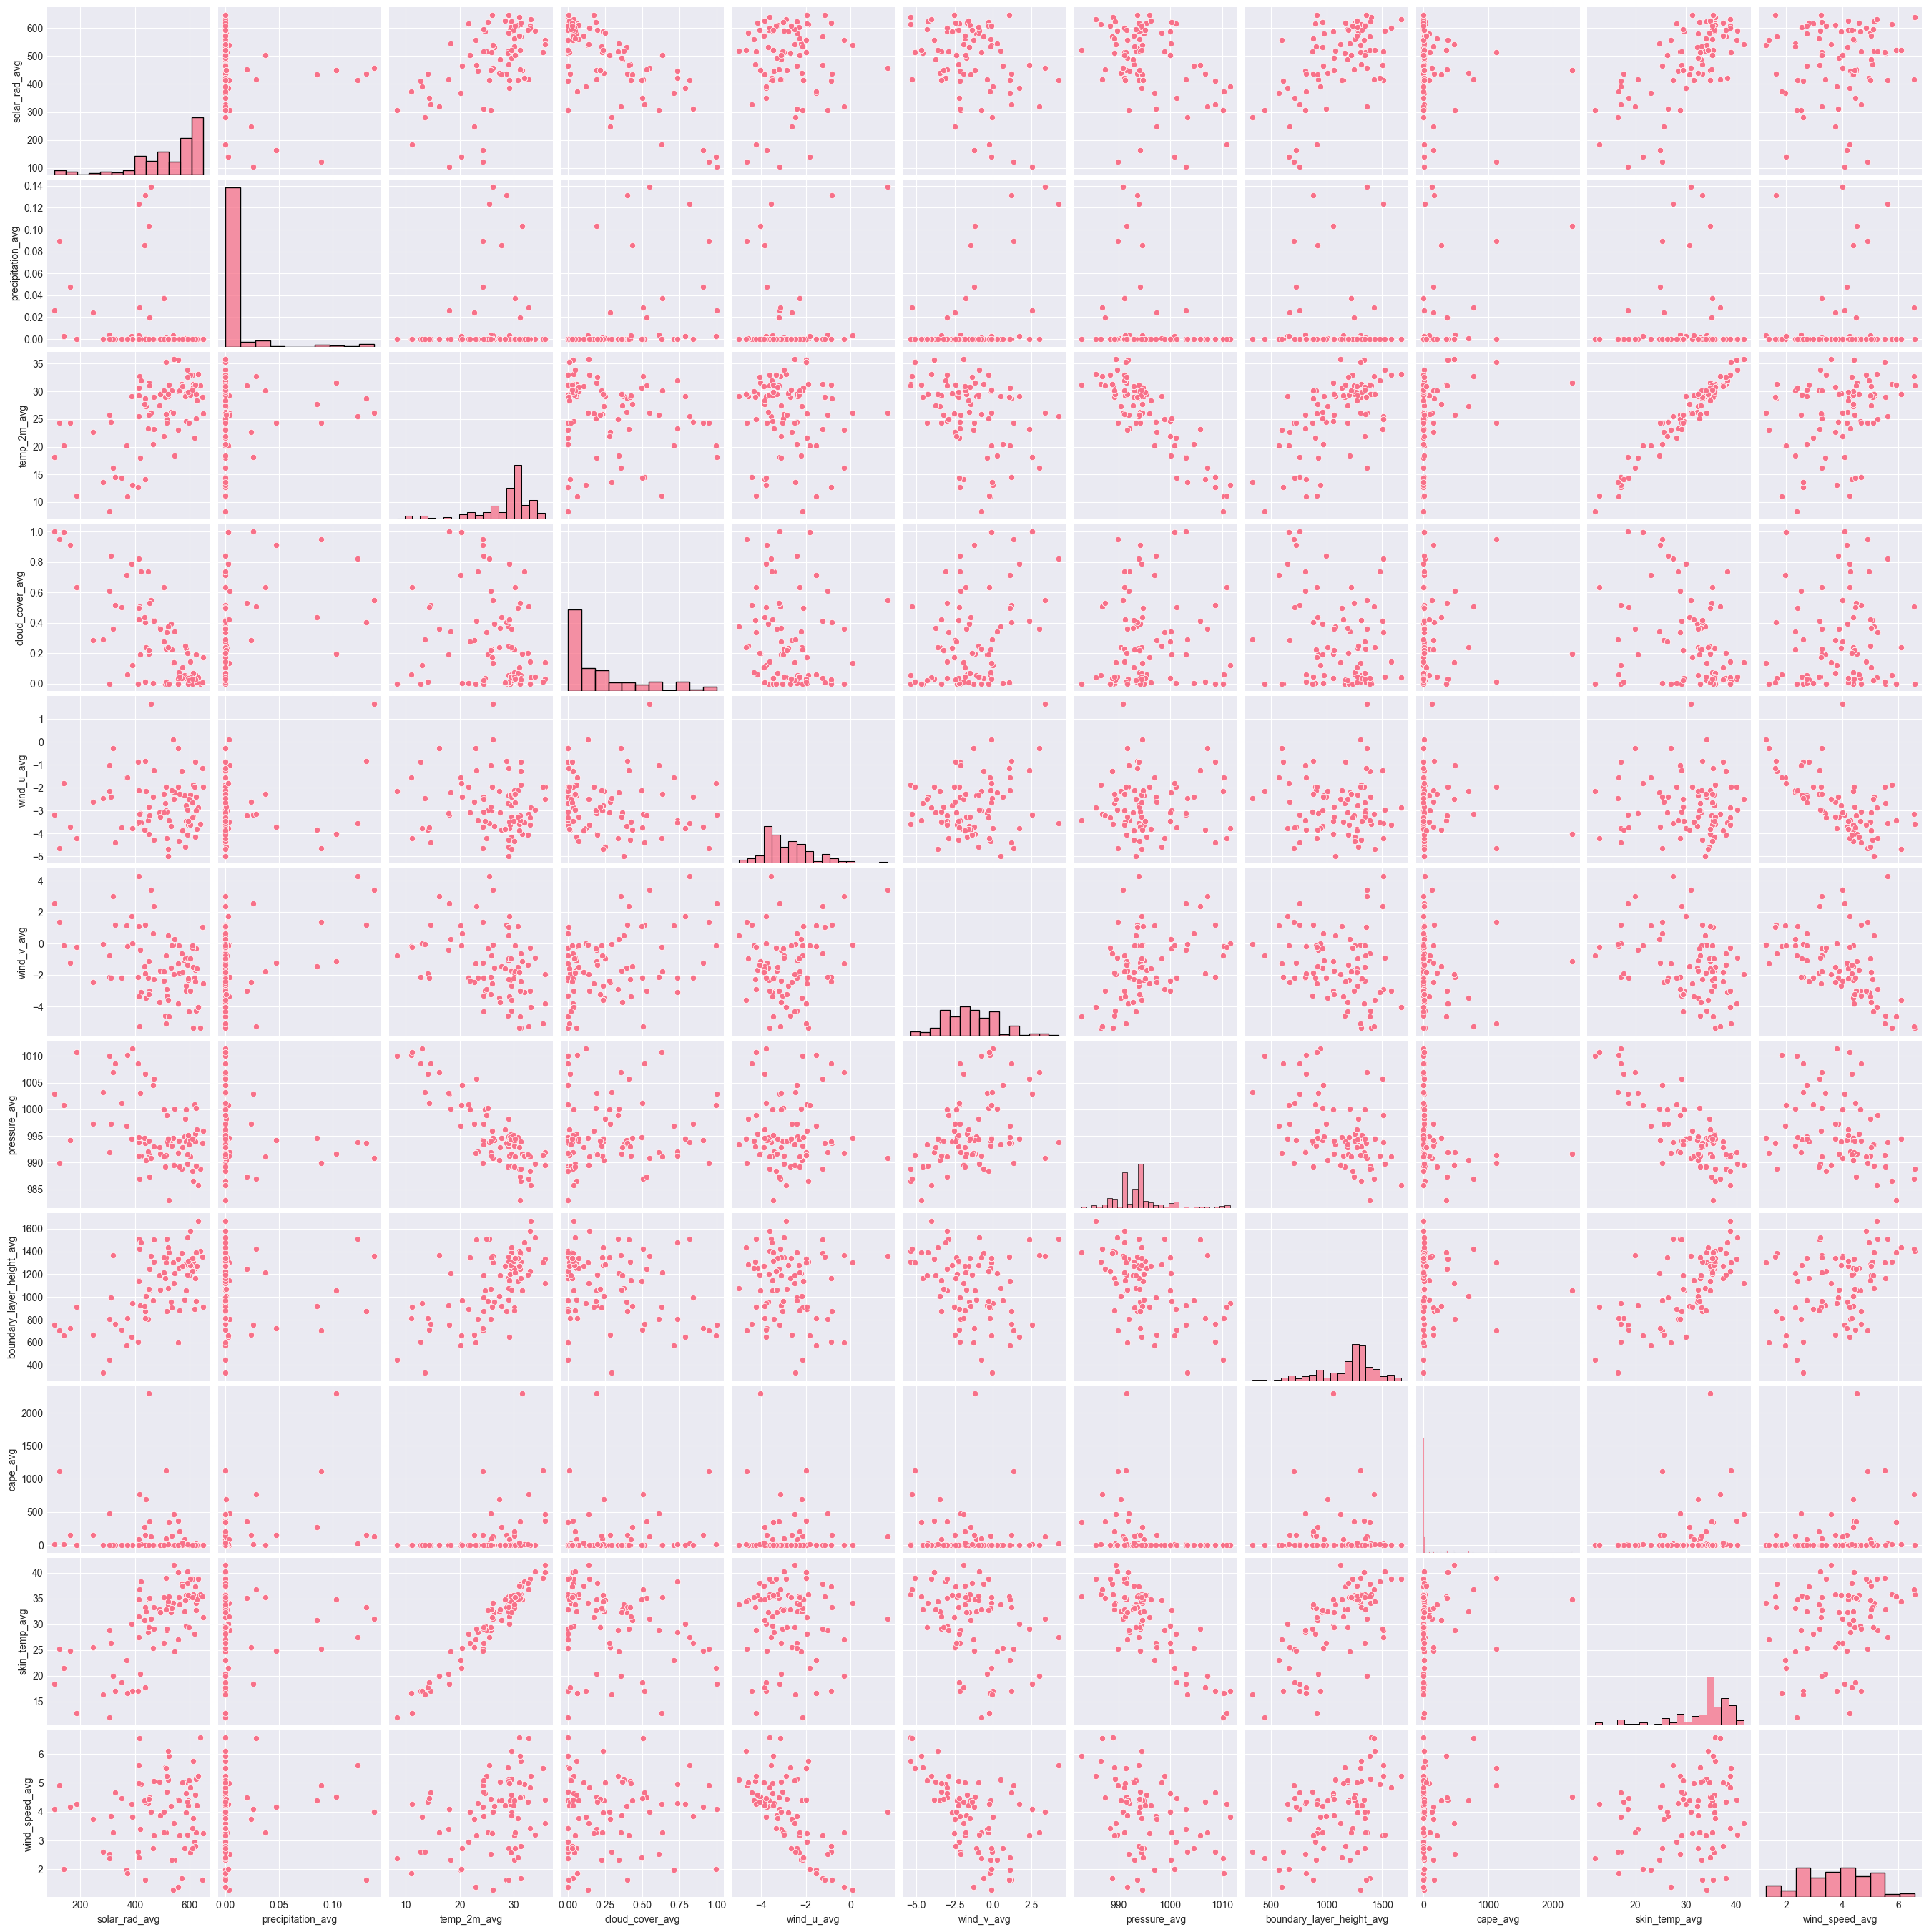

In [15]:
sns.pairplot(dev, vars=weather_avg)

In [16]:
dev.to_csv("../data/processed/dev.csv", index=True)
test.to_csv("../data/processed/test.csv", index=True)

## Estandarizacion de los datos
Como no es necesario estandarizar los datos para todos los modelos esa parte se dejará para mas adelante. Se implementara de considerarse necesario en la seccion de desarrollo de los modelos